# Exercise Week 9: Pruning and Quantization
This week, we will explore some of the ideas discussed in Han, Mao, and Dally's Deep Compression.  In particular, we will implement weight pruning with fine tuning, as well as k-means weight quantization.  **Note that we will unfortunately not be doing this in a way that will actually lead to substantial efficiency gains: that would involve the use of sparse matrices which are not currently well-supported in pytorch.** 

## Training an MNIST classifier
For this example, we'll work with a basic multilayer perceptron with a single hidden layer.  We will train it on the MNIST dataset so that it can classify handwritten digits.  As usual we load the data:

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

batch_size = 300
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Then define a model:

In [23]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,mask=None):
        super(MultilayerPerceptron, self).__init__()
        if not mask:
            self.mask = torch.nn.Parameter(torch.ones(input_dim,hidden_dim),requires_grad=False)
        else:
            self.mask = torch.nn.Parameter(mask)

        self.W_0 = torch.nn.Parameter(1e-3*torch.randn(input_dim,hidden_dim)*self.mask,requires_grad=True)
        self.b_0 = torch.nn.Parameter(torch.zeros(hidden_dim),requires_grad=True)

        self.W_1 = torch.nn.Parameter(1e-3*torch.randn(hidden_dim,output_dim),requires_grad=True)
        self.b_1 = torch.nn.Parameter(torch.zeros(output_dim),requires_grad=True)
        
    def set_mask(self,mask):
        
        self.mask.data = mask.data
        self.W_0.data = self.mask.data*self.W_0.data

    def forward(self, x):
        hidden = torch.tanh(x@(self.W_0*self.mask) + self.b_0)
        outputs = hidden@self.W_1 + self.b_1
        return outputs


Note that the above code is a little bit different than a standard multilayer perceptron implementation.

### Q1: What does this model have the capability of doing that a "Vanilla" MLP does not.  Why might we want this functionality for studying pruning?

##### Answer
You have the ability to turn on or off weights that that are not needed. In other words the mask is currently a tensor full of ones. So elementwise multiplication of the weights does not remove any weights. If we change elementes in the mask to zero, we have a way of effectivly setting weights to zero within the MLP.



Let's first train this model without utilizing this extra functionality.  You can set the hidden layer size to whatever you'd like when instantiating the model:

In [24]:
n_epochs = 10

input_dim = 784
hidden_dim = 64
output_dim = 10

model = MultilayerPerceptron(input_dim,hidden_dim,output_dim)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
lr_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate, weight_decay=1e-3)

And then training proceeds as normal.

In [25]:
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(epoch, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_pretrained.h5')


Iteration: 0. Loss: 0.41548487544059753. Accuracy: 90.
Iteration: 1. Loss: 0.34457167983055115. Accuracy: 92.
Iteration: 2. Loss: 0.2686581611633301. Accuracy: 93.
Iteration: 3. Loss: 0.20769262313842773. Accuracy: 94.
Iteration: 4. Loss: 0.2652377486228943. Accuracy: 94.
Iteration: 5. Loss: 0.18059997260570526. Accuracy: 94.
Iteration: 6. Loss: 0.12396704405546188. Accuracy: 95.
Iteration: 7. Loss: 0.15603581070899963. Accuracy: 95.
Iteration: 8. Loss: 0.1408979594707489. Accuracy: 95.
Iteration: 9. Loss: 0.12788546085357666. Accuracy: 95.


## Pruning

Certainly not a state of the art model, but also not a terrible one.  Because we're hoping to do some weight pruning, let's inspect some of the weights directly (recall that we can act like they're images)

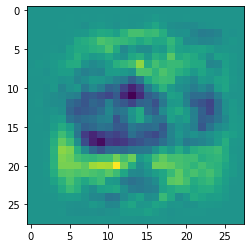

In [26]:
import matplotlib.pyplot as plt
W_0 = model.W_0.detach().cpu().numpy()
plt.imshow(W_0[:,1].reshape((28,28)))
plt.show()

### Q2: Based on the above image, what weights might reasonably be pruned (i.e. explicitly forced to be zero)?

##### Answer
The weights around the edge of the domain, where the pixels appear to all be about the same value. This do no appear to be important in solving this problem.

### Q3: Implement some means of establishing a threshold for the (absolute value of the) weights, below which they are set to zero.  Using this method, create a mask array.     

In [30]:
new_mask = model.mask
weights = model.W_0
new_mask[(abs(weights)>-1)] = 1. #reset the mask
total_weights = torch.sum(new_mask)
print(model.mask)
new_mask[(abs(weights)<.09)] = 0 #arbitrary cutoff point
print(model.mask)
print(new_mask.max(), new_mask.min()) #make sure I'm turning on and off some labels
print(torch.sum(new_mask)/total_weights) #fraction of remaining weights

Parameter containing:
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(1.) tensor(0.)
tensor(0.0601)


Now that we have a mask that explicitly establishes a sparsity pattern for our model, let's update our model with this mask:

In [31]:
model.set_mask(new_mask)

Now, we have explicitly set some entries in one of the the weight matrices to zero, and ensured via the mask, that they will not be updated by gradient descent.  Fine tune the model: 

In [32]:
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_pruned.h5')

Iteration: 0. Loss: 0.18822796642780304. Accuracy: 94.
Iteration: 0. Loss: 0.26867660880088806. Accuracy: 94.
Iteration: 0. Loss: 0.19309568405151367. Accuracy: 95.
Iteration: 0. Loss: 0.2145838737487793. Accuracy: 95.
Iteration: 0. Loss: 0.13824479281902313. Accuracy: 95.
Iteration: 0. Loss: 0.1683703511953354. Accuracy: 95.
Iteration: 0. Loss: 0.13571622967720032. Accuracy: 95.
Iteration: 0. Loss: 0.20217075943946838. Accuracy: 95.
Iteration: 0. Loss: 0.1596449613571167. Accuracy: 95.
Iteration: 0. Loss: 0.14204254746437073. Accuracy: 95.


### Q4: How much accuracy did you lose by pruning the model?  How much "compression" did you achieve (here defined as total entries in W_0 divided by number of non-zero entries)?  

##### Answer
NOTE: This description was relevant for a previous run of the notebook, results have changed slightly with secondary run.

For the first experiment, I set threshold that the absolute value of the weight must be greater than 1e-12. This choice was arbitrary, but at least removed the edge weights which were around 1e-32. I enjoyed an accuracy increase from 95 to 96 percent. 82% weights remain

I then changes my threshold to the absolute value greater than 1e-5, and continued to achieve gains from the network up to 97 percent. 77% weights remain

I then changes my threshold to the absolute value greater than 1e-3, and continued to achieve gains from the network up to 97 percent. 72% weights remain

I then changed my threshold to the absolute value greater than .05 to be more aggresive, and continued to have a very functional network at 97 percent accuracy. 17% weights remain

I then changed my threshold to the absolute value greater than .15 to be more aggresive, and continued to have a very functional network accuracy but accurace is starting to degrade. Interestingly enough, the network accuracy initially dropped to 91 percent then it retrainted to 94 percent accuracy. 1.5% weights remain

### Q5: Explore a few different thresholds: approximately how many weights can you prune before accuracy starts to degrade?

The network is remarkably functional even with 98.5% of the weights removed. This is quite remarkable. This means that after initial training, only a few percent of the weights are actually necessary to classify mnist. See picture below for some 94% accuracy weights. 

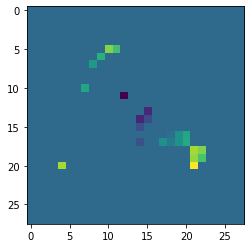

In [34]:
W_0 = model.W_0.detach().cpu().numpy()
plt.imshow(W_0[:,7].reshape((28,28)))
plt.show()

## Quantization

Now that we have a pruned model that appears to be performing well, let's see if we can make it even smaller by quantization.  To do this, we'll need a slightly different neural network, one that corresponds to Figure 3 from the paper.  Instead of having a matrix of float values, we'll have a matrix of integer labels (here called "labels") that correspond to entries in a (hopefully) small codebook of centroids (here called "centroids").  The way that I've coded it, there's still a mask that enforces our desired sparsity pattern.

In [35]:
class MultilayerPerceptronQuantized(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim,mask,labels,centroids):
        super(MultilayerPerceptronQuantized, self).__init__()
        self.mask = torch.nn.Parameter(mask,requires_grad=False)
        self.labels = torch.nn.Parameter(labels,requires_grad=False)
        self.centroids = torch.nn.Parameter(centroids,requires_grad=True)

        self.b_0 = torch.nn.Parameter(torch.zeros(hidden_dim))

        self.W_1 = torch.nn.Parameter(1e-3*torch.randn(hidden_dim,output_dim))
        self.b_1 = torch.nn.Parameter(torch.zeros(output_dim))

    def forward(self, x):
        W_0 = self.mask*self.centroids[self.labels]
        hidden = torch.tanh(x@W_0 + self.b_0)
        outputs = hidden@self.W_1 + self.b_1
        return outputs

Notice what is happening in the forward method: W_0 is being reconstructed by using a matrix (self.labels) to index into a vector (self.centroids).  The beauty of automatic differentiation allows backpropogation through this sort of weird indexing operation, and thus gives us gradients of the objective function with respect to the centroid values!

### Q6: However, before we are able to use this AD magic, we need to specify the static label matrix (and an initial guess for centroids).  Use the k-means algorithm (or something else if you prefer) figure out the label matrix and centroid vectors.  PROTIP1: I used scikit-learns implementation of k-means.  PROTIP2: only cluster the non-zero entries

In [69]:
import numpy as np
from sklearn.cluster import KMeans
# convert weight and mask matrices into numpy arrays
W_0 = model.W_0.detach().cpu().numpy()
mask = model.mask.detach().cpu().numpy()

# Figure out the indices of non-zero entries 
inds = np.where(mask!=0)

# Figure out the values of non-zero entries
vals = W_0[inds]

### TODO: perform clustering on vals
kmeans = KMeans(n_clusters = 1).fit(W_0)

### TODO: turn the label matrix and centroids into a torch tensor

labels = torch.tensor(kmeans.labels_, dtype=torch.long, device=device)
centroids = torch.tensor(kmeans.cluster_centers_, device=device)

Now, we can instantiate our quantized model and import the appropriate pre-trained weights for the other network layers.  

In [70]:
# Instantiate quantized model
model_q = MultilayerPerceptronQuantized(input_dim,output_dim,hidden_dim,new_mask,labels,centroids)
model_q = model_q.to(device)

# Copy pre-trained weights from unquantized model for non-quantized layers
model_q.b_0.data = model.b_0.data
model_q.W_1.data = model.W_1.data
model_q.b_1.data = model.b_1.data

Finally, we can fine tune the quantized model.  We'll adjust not only the centroids, but also the weights in the other layers.

In [71]:
optimizer = torch.optim.Adam(model_q.parameters(), lr=lr_rate, weight_decay=1e-3)
iter = 0
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_q(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # calculate Accuracy
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model_q(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct/total
    print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))
torch.save(model.state_dict(),'mnist_quantized.h5')

Iteration: 0. Loss: 0.4437963366508484. Accuracy: 88.
Iteration: 0. Loss: 0.38359904289245605. Accuracy: 89.
Iteration: 0. Loss: 0.43179452419281006. Accuracy: 89.
Iteration: 0. Loss: 0.3722302317619324. Accuracy: 89.
Iteration: 0. Loss: 0.3560977280139923. Accuracy: 89.
Iteration: 0. Loss: 0.3747432231903076. Accuracy: 89.
Iteration: 0. Loss: 0.3805023729801178. Accuracy: 89.
Iteration: 0. Loss: 0.39596956968307495. Accuracy: 89.
Iteration: 0. Loss: 0.39233332872390747. Accuracy: 89.
Iteration: 0. Loss: 0.35189899802207947. Accuracy: 90.


After retraining, we can, just for fun, reconstruct the pruned and quantized weights and plot them as images:

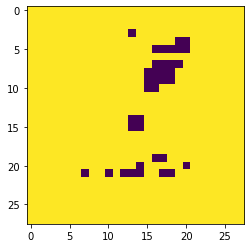

In [72]:
W_0 = (model_q.mask*model_q.centroids[model_q.labels]).detach().cpu().numpy()
plt.imshow(W_0[:,45].reshape((28,28)))
plt.show()

Certainly a much more parsimonious representation.  The obvious question now becomes:

### Q7: How low can you go?  How small can the centroid codebook be before we see a substantial degradation in test set accuracy?
With 3 Centroids, accuracy degrades a little bit, by a few percent, but still is training to around 92 percent accuracy.

With 2 Centroids, I start to see an accuracy decrease of around 5 percent to around 89 percent, which is still remarkably good. It may indicate that mnist is a very easy problem to solve in practice. 

Even with 1 centroid accuracy is 90 percent. This is quite interesting, apparently having a single centroid is still quite capable network. 

### Bonus question: Try establishing the sparsity pattern using a model that's only been trained for a single epoch, then fine tune the pruned model and quantize as normal.  How does this compare to pruning a model that has been fully trained?  